# Task

### Pre-defined code

In [1]:
# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
from scipy.ndimage import convolve
style.use('ggplot')

In [4]:
# Load images from the folder to an array
image_folder = '../../data/images/B'  
gt_images = []

# Load all images from the folder
for file in tqdm(natsorted(glob(f'{image_folder}/*'))):
    img = cv2.imread(file, 1)  
    if img is not None:       
        gt_images.append(img)

if len(gt_images) > 0:
    gt_images = np.array(gt_images)
    print("Loaded images into an array with shape:", gt_images.shape)
else:
    print("No images were found in the specified folder.")

100%|██████████| 7/7 [00:00<00:00, 209.76it/s]

Loaded images into an array with shape: (6, 512, 512, 3)


In [9]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

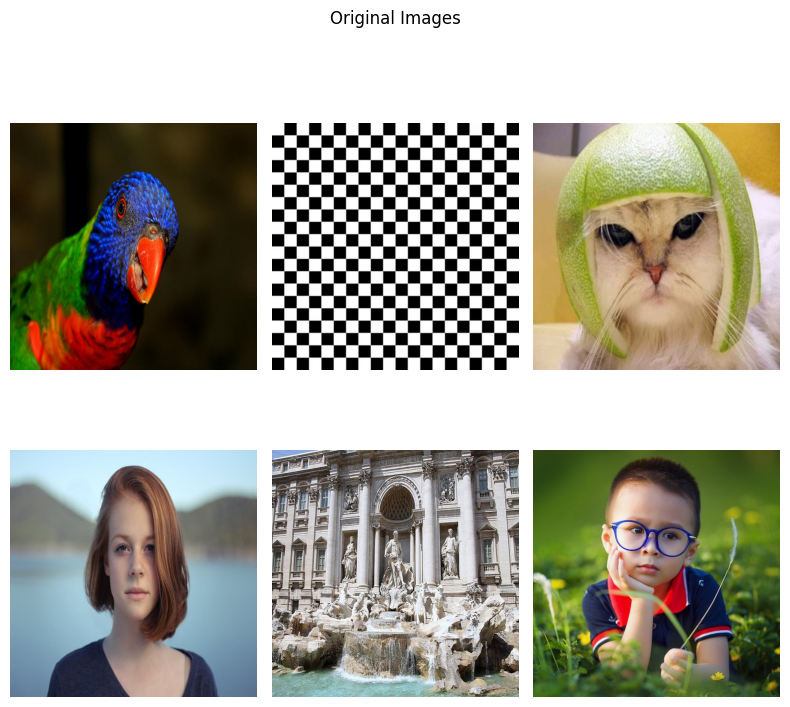

In [ ]:
show_image_grid(gt_images, 2, 3, 'Original Images', figsize=8)

### Q1 [2 Marks]

Implement Gaussian Pyramid Downsampling method from scratch.Compare it with Opencv resize method. What difference do you observe when you resize an image with Gaussian Pyramid approach and Opencv approach.

References:
1. [Gaussian & Laplacian pyramid	construction](https://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf)
2. [Multi-Scale Representation](https://medium.com/jun94-devpblog/cv-4-multi-scale-representation-gaussian-and-laplacian-pyramid-527ca4c4831c)

In [ ]:
def pad_image_to_divisible(image, K, pad_value=0):
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the padding needed for height and width
    pad_h = (K - (h % K)) % K  # Padding needed for height
    pad_w = (K - (w % K)) % K  # Padding needed for width

    # Compute the padding to add to top/bottom and left/right
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    # Pad the image: (top, bottom), (left, right), and (no padding on channels)
    if len(image.shape) == 3:  # For RGB images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                              mode='constant', constant_values=pad_value)
    else:  # For grayscale images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)),
                              mode='constant', constant_values=pad_value)

    return padded_image

In [ ]:
def gaussian_pyramid(image, levels, kernel_size=5, sigma=1.0):

    def gaussian_kernel(size, sigma=1.0):
        # Create a Gaussian kernel of a given size and standard deviation.
        ax = np.arange(-size // 2 + 1., size // 2 + 1.)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
        return kernel / np.sum(kernel)

    def apply_gaussian_blur(image, kernel):
        # Apply Gaussian blur by convolving the image with the Gaussian kernel.
        blurred_image = np.zeros_like(image)
        if image.ndim == 3:  # RGB Image
            for i in range(3):  # Apply to each channel
                blurred_image[:, :, i] = convolve(image[:, :, i], kernel, mode='reflect')
        else:  # Grayscale Image
            blurred_image = convolve(image, kernel, mode='reflect')
        return blurred_image

    def downsample(image):
        # Downsample the image by a factor of 2
        return image[::2, ::2]

    pyramid = [image]
    kernel = gaussian_kernel(kernel_size, sigma)

    for i in range(levels - 1):
        # Write your code here
        # Apply Gaussian blur
        image = apply_gaussian_blur(image, kernel)

        # Downsample by a factor of 2
        image = downsample(image)

        image = pad_image_to_divisible(image, pyramid[0].shape[0])
        pyramid.append(image)

    return np.array(pyramid)

def opencv_resize(inp_image, levels):
    pyramid = []
    h, w    = inp_image.shape[:2]
    for i in range(levels):
        # Apply Gaussian blur and downsample by a factor of 2
        # Write code here
        image = cv2.resize(inp_image, (h//2**i, w//2**i))

        image = pad_image_to_divisible(image, min(h, w))
        pyramid.append(image)

    return np.array(pyramid)

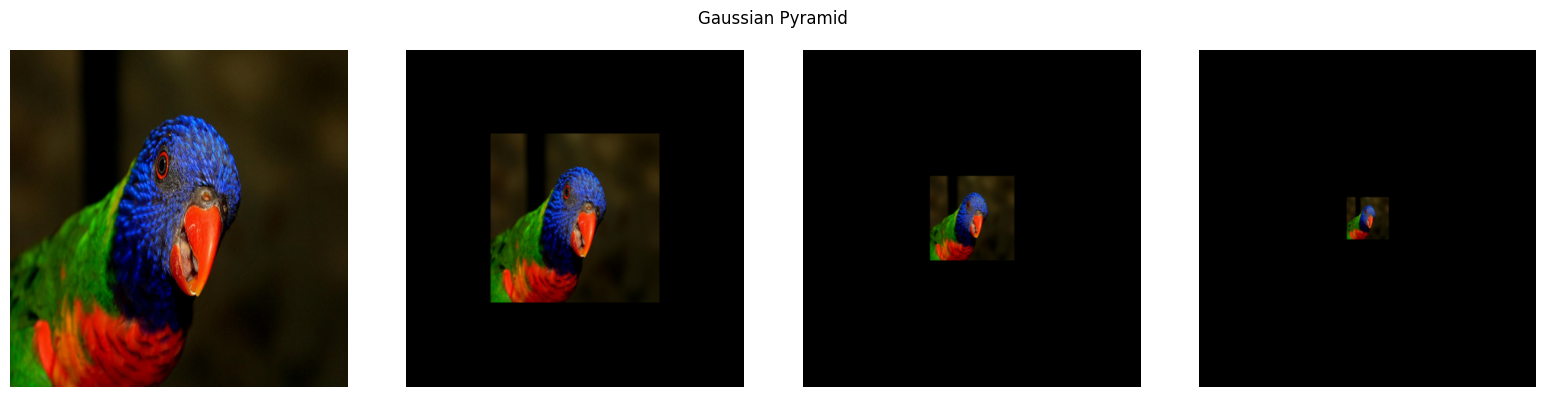

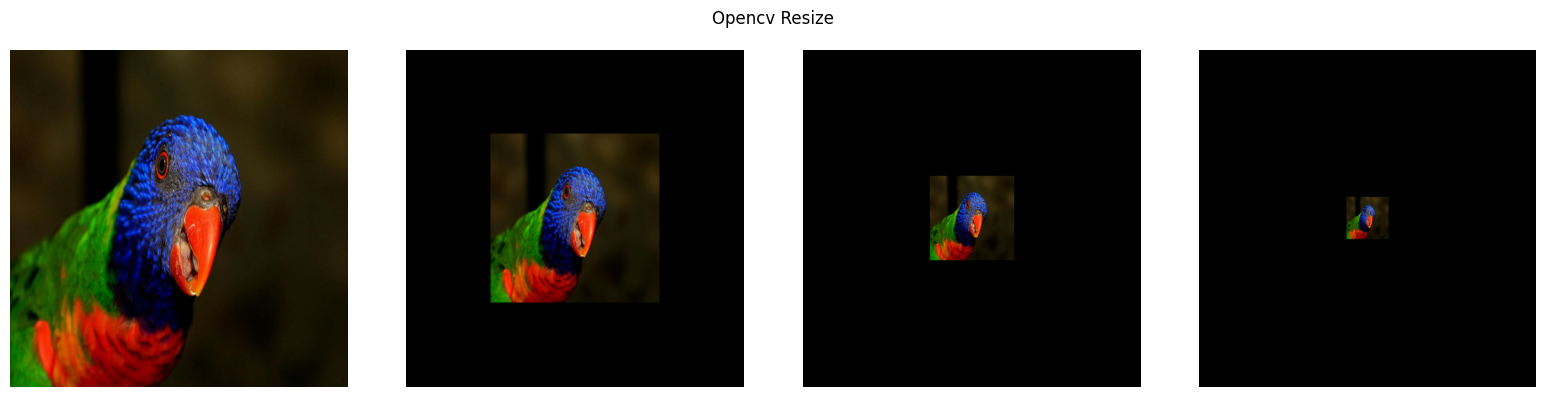

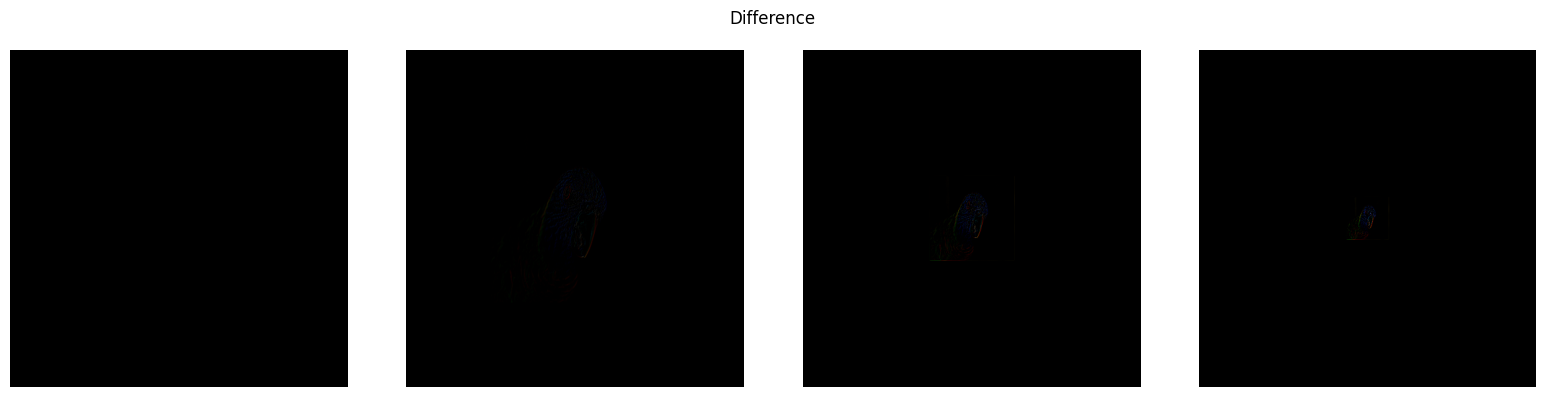

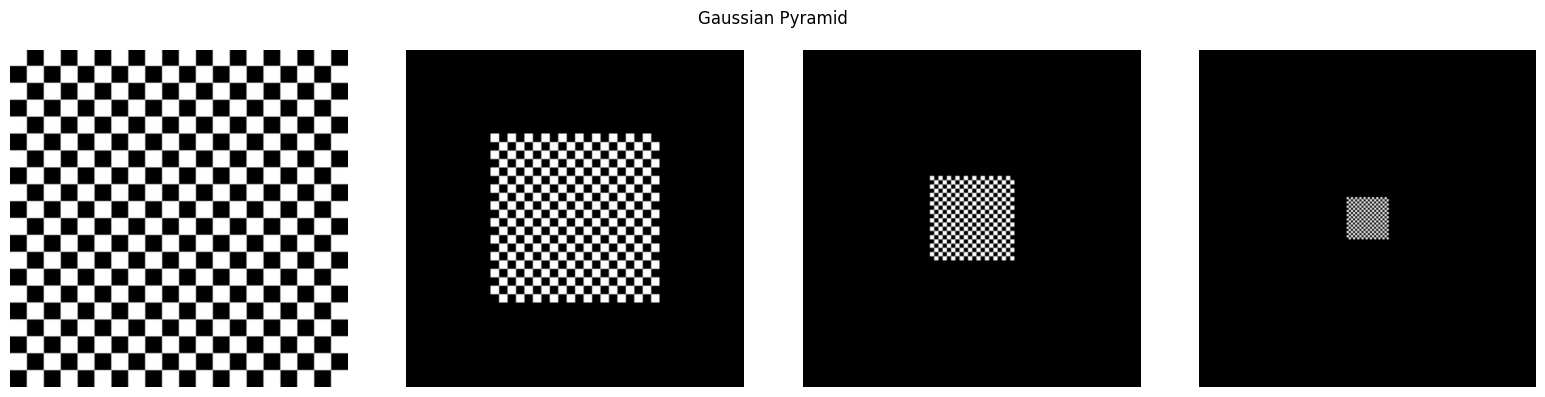

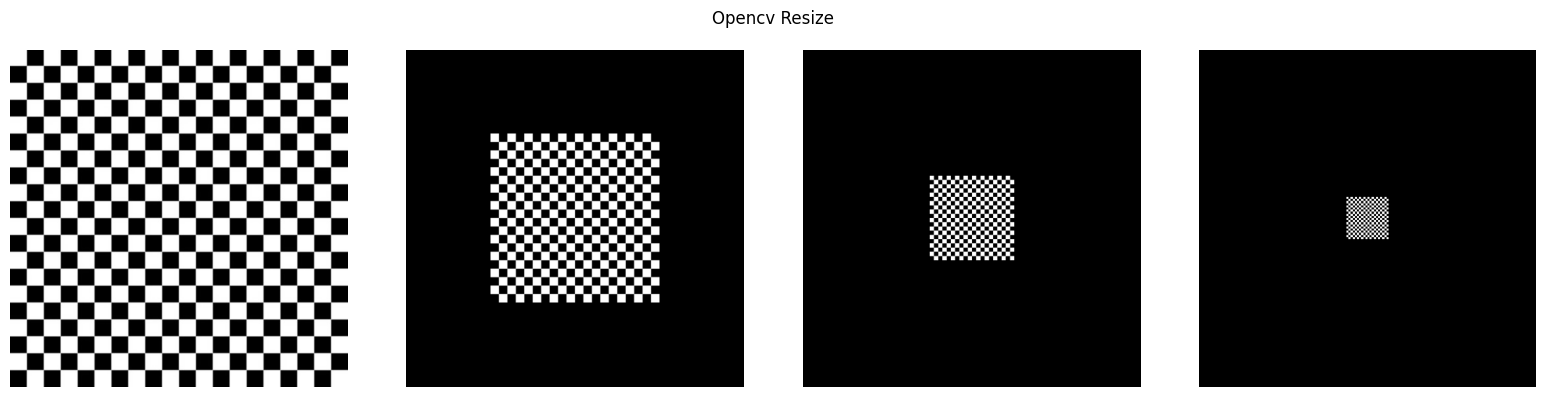

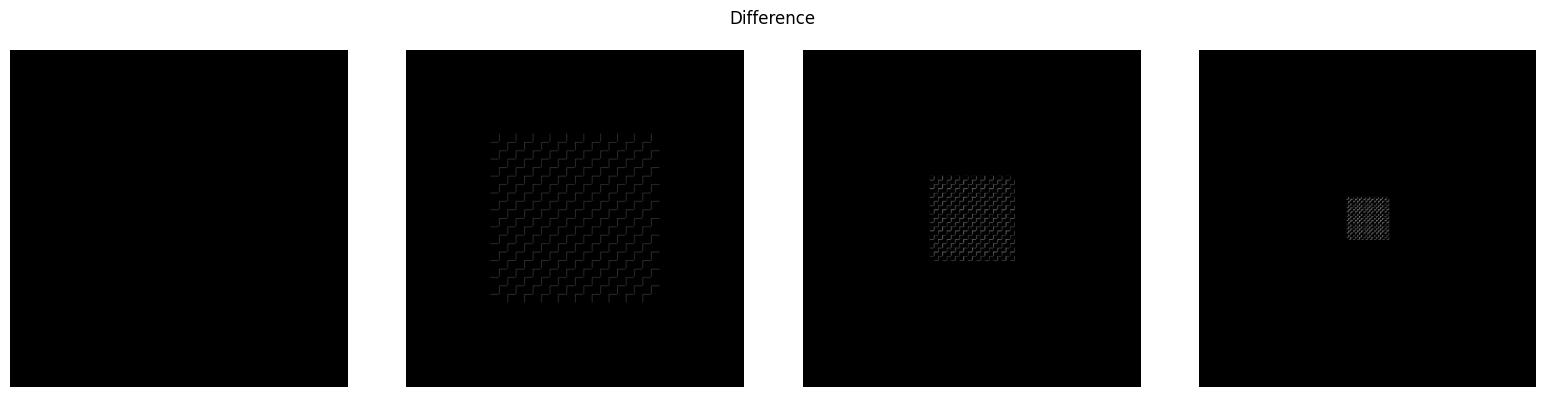

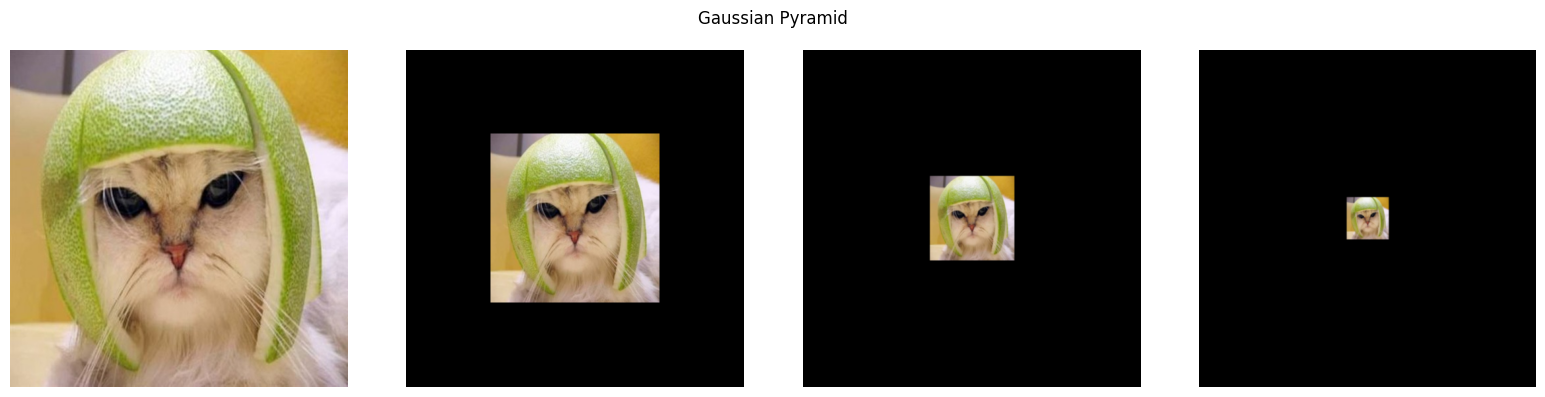

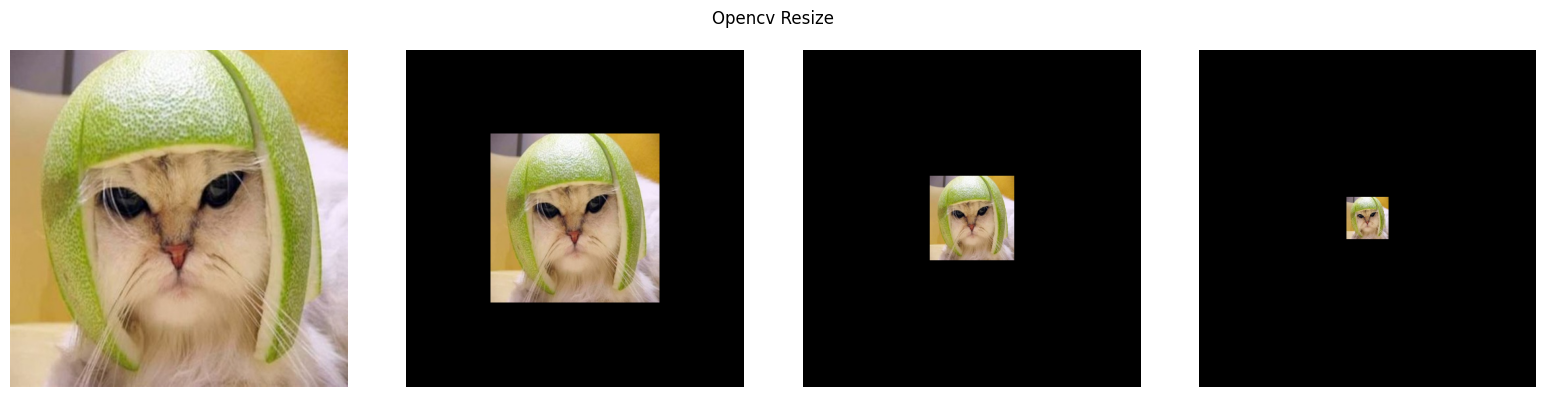

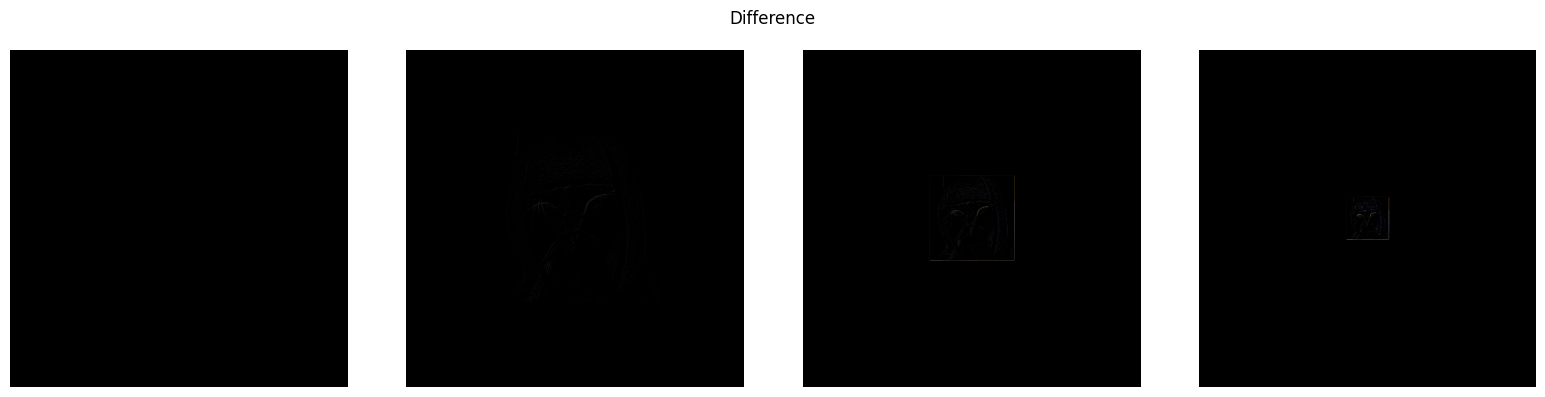

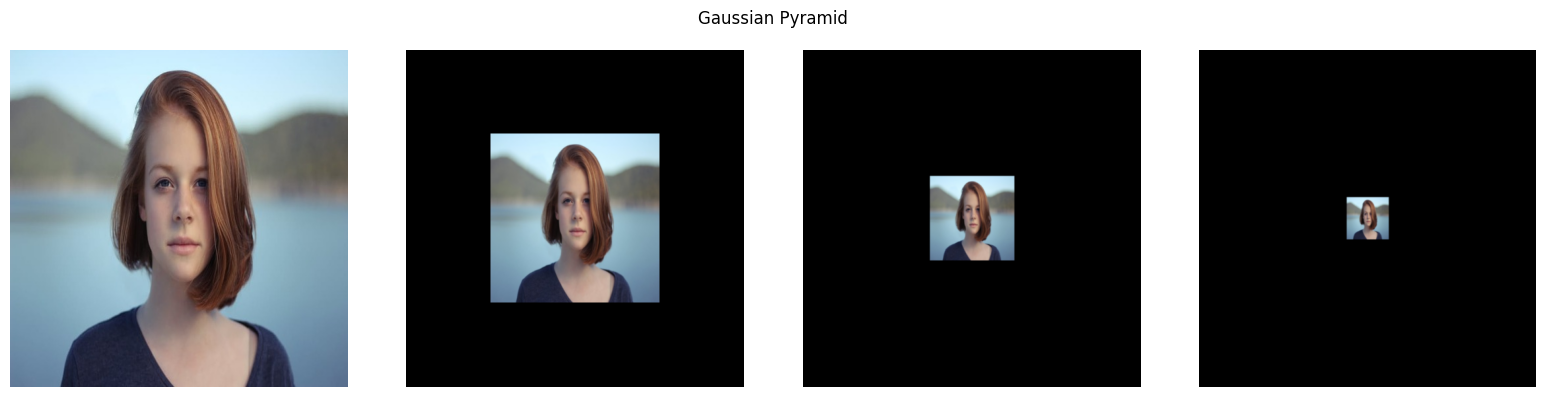

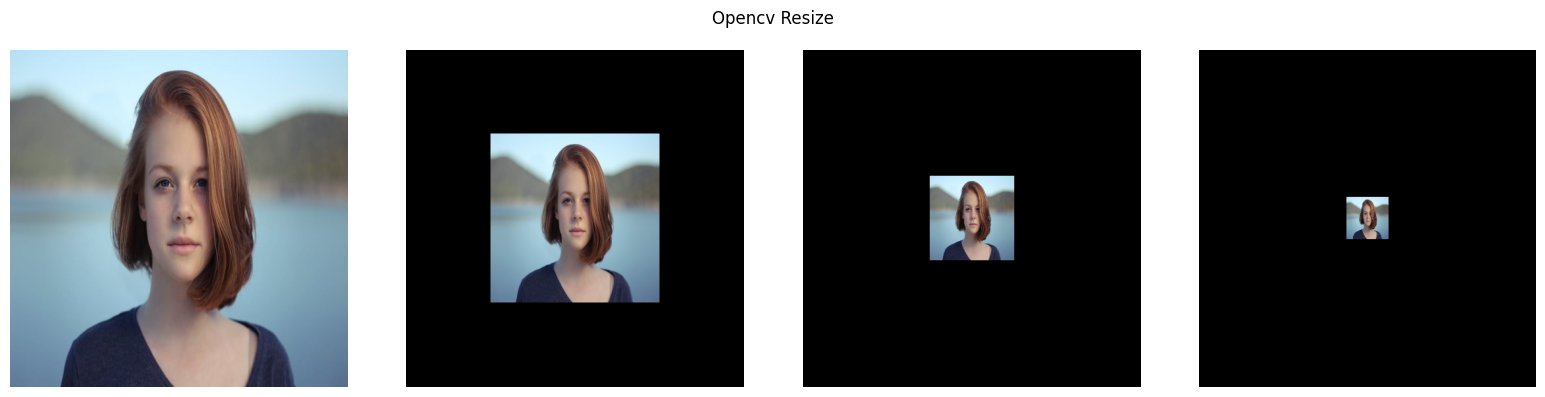

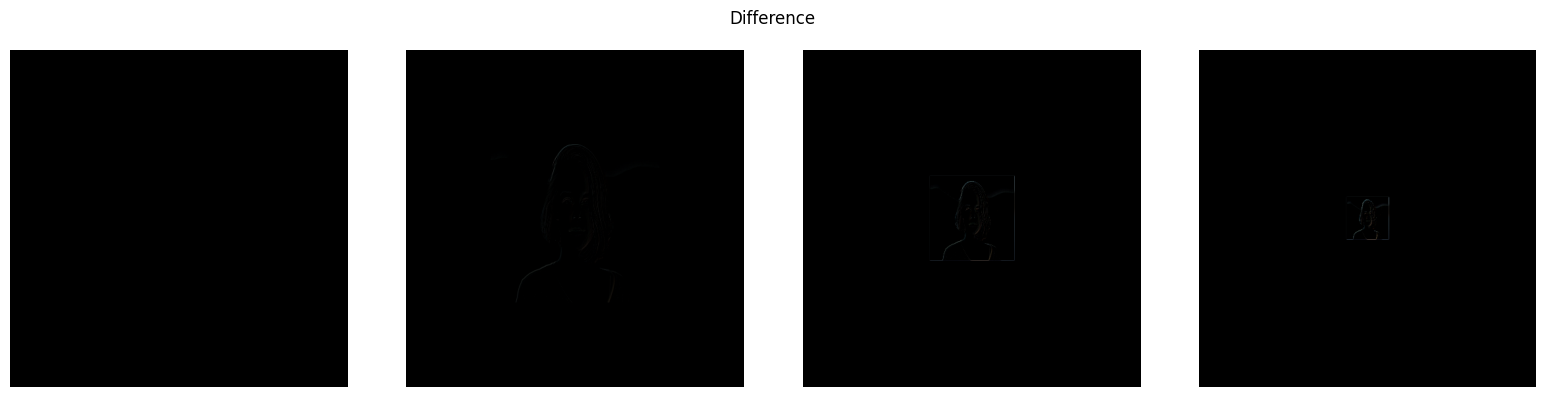

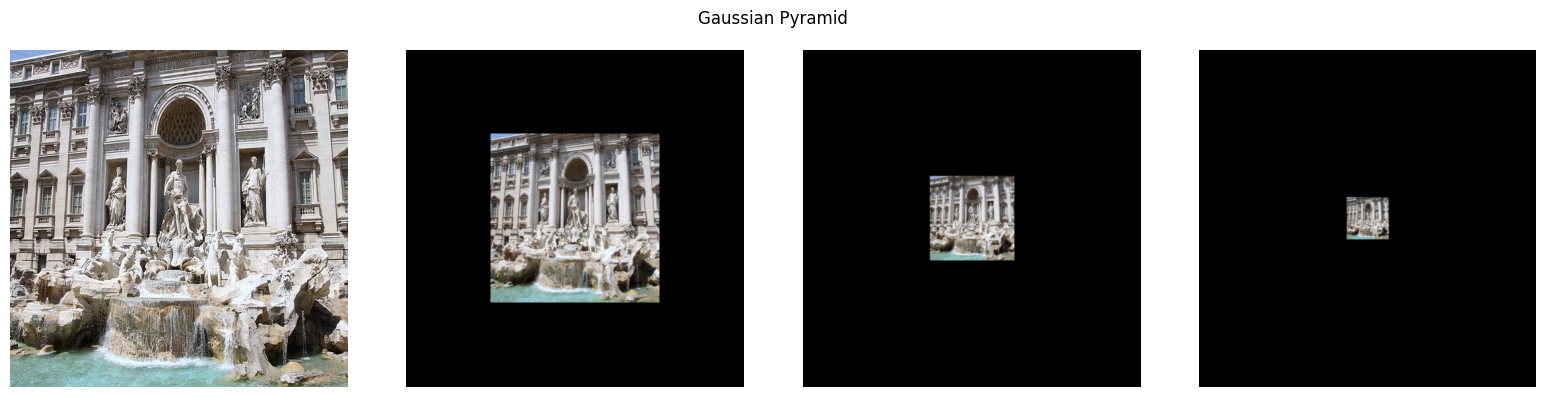

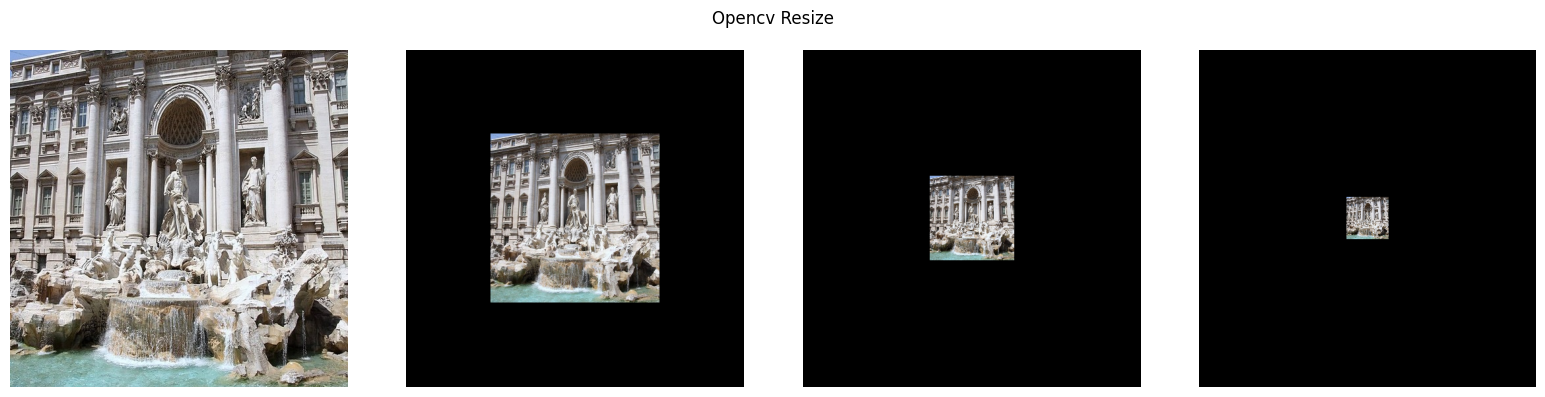

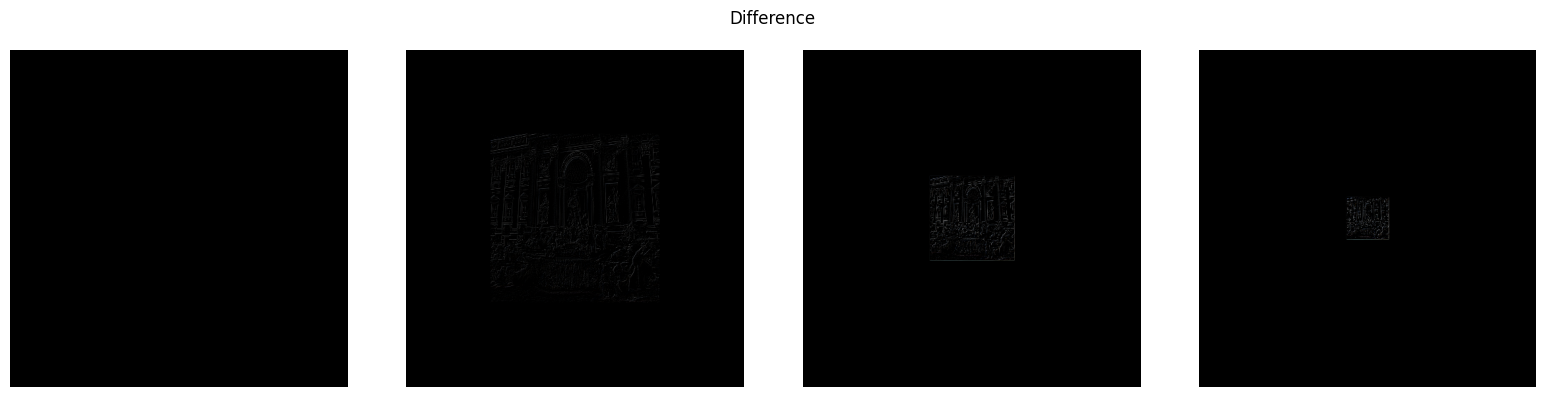

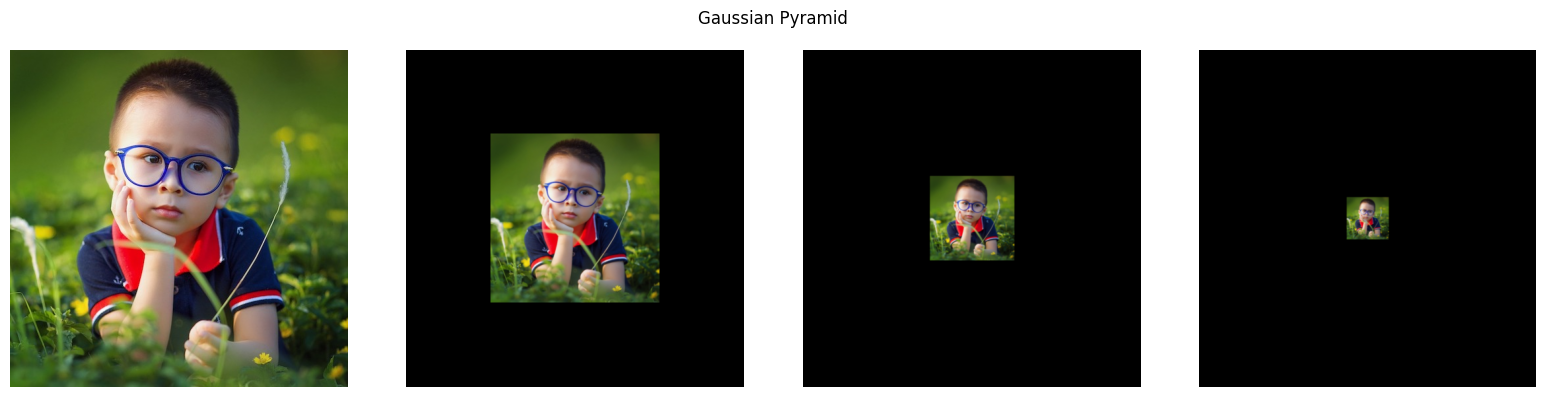

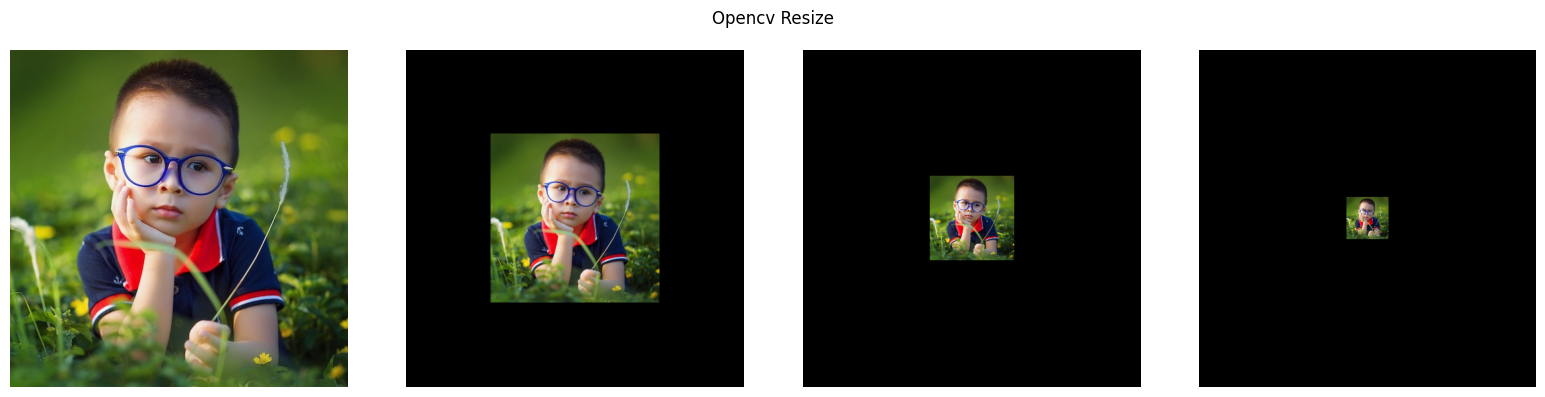

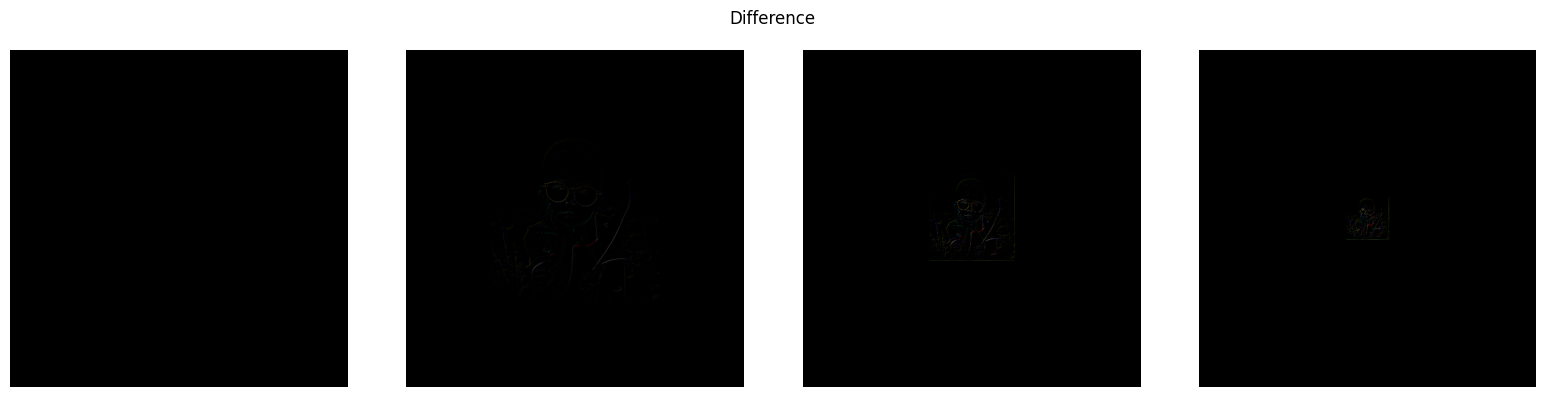

In [ ]:
for idx, image in enumerate(gt_images):

    # Generate pyramid of images for matching
    s_image_pyramids = gaussian_pyramid(image, levels=4)
    s_image_opecv_resize = opencv_resize(image, levels=4)

    diff = []
    for gauss_img, open_img in zip(s_image_pyramids, s_image_opecv_resize):
        diff.append(cv2.subtract(gauss_img, open_img))
    diff = np.array(diff)

    show_image_grid(s_image_pyramids, 1, 4, 'Gaussian Pyramid', figsize=16)
    show_image_grid(s_image_opecv_resize, 1, 4, 'Opencv Resize', figsize=16)
    show_image_grid(diff, 1, 4, 'Difference', figsize=16)

### Q2 [4 Marks]

You have to implement image blending technique using Laplacian Pyramids from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Image Blending Using Laplacian Pyramids](https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f)

In [7]:
def laplacian_pyramid_blend_images(img1, img2, levels=6):

    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions.")

    gp_img1 = [img1.copy()]
    gp_img2 = [img2.copy()]

    # Create Gaussian pyramids by cv2.resize
    for _ in range(levels):
        img1_copy = cv2.resize(gp_img1[-1], (gp_img1[-1].shape[1] // 2, gp_img1[-1].shape[0] // 2))
        img2_copy = cv2.resize(gp_img2[-1], (gp_img2[-1].shape[1] // 2, gp_img2[-1].shape[0] // 2))
        gp_img1.append(img1_copy)
        gp_img2.append(img2_copy)

    # Create Laplacian pyramid for both images
    lp_img1 = [gp_img1[levels]]
    lp_img2 = [gp_img2[levels]]

    for i in range(levels, 0, -1):
        gaussian_expanded_img1 = cv2.resize(gp_img1[i], (gp_img1[i-1].shape[1], gp_img1[i-1].shape[0]))
        laplacian_img1 = cv2.subtract(gp_img1[i-1], gaussian_expanded_img1)
        lp_img1.append(laplacian_img1)

        gaussian_expanded_img2 = cv2.resize(gp_img2[i], (gp_img2[i-1].shape[1], gp_img2[i-1].shape[0]))
        laplacian_img2 = cv2.subtract(gp_img2[i-1], gaussian_expanded_img2)
        lp_img2.append(laplacian_img2)

    # Merge the left and right halves
    blended_image_pyramid = []
    for lap1, lap2 in zip(lp_img1, lp_img2):
        cols = lap1.shape[1]
        laplacian_merged = np.hstack((lap1[:, :cols//2], lap2[:, cols//2:]))
        blended_image_pyramid.append(laplacian_merged)

    # Reconstruct the blended image
    blended_image = blended_image_pyramid[0]
    for i in range(1, levels + 1):
        blended_image = cv2.resize(blended_image, (blended_image_pyramid[i].shape[1], blended_image_pyramid[i].shape[0]))
        if i < len(blended_image_pyramid):
            blended_image = cv2.add(blended_image_pyramid[i], blended_image)

    return blended_image

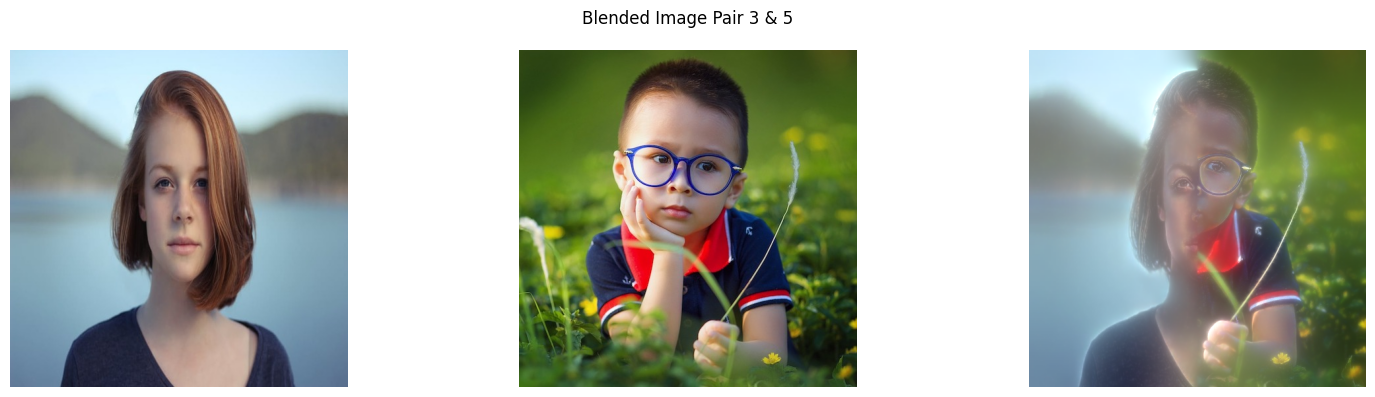

In [ ]:
blended_image = laplacian_pyramid_blend_images(gt_images[3], gt_images[5])
collage = np.array([gt_images[3], gt_images[5], blended_image])
show_image_grid(collage, 1, 3, 'Blended Image Pair 3 & 5', figsize=16)

In [6]:
to_blend = []
resize_shape = (256, 256)

# Loop through the images, resize, and append
for file in tqdm(natsorted(glob('../../data/images/B/Blending/*'))):
    image = cv2.imread(file, 1)  # Read the image
    resized_image = cv2.resize(image, resize_shape)  # Resize the image
    to_blend.append(resized_image)

to_blend = np.array(to_blend) # Only possible because all images are of same size

100%|██████████| 2/2 [00:00<00:00, 141.26it/s]


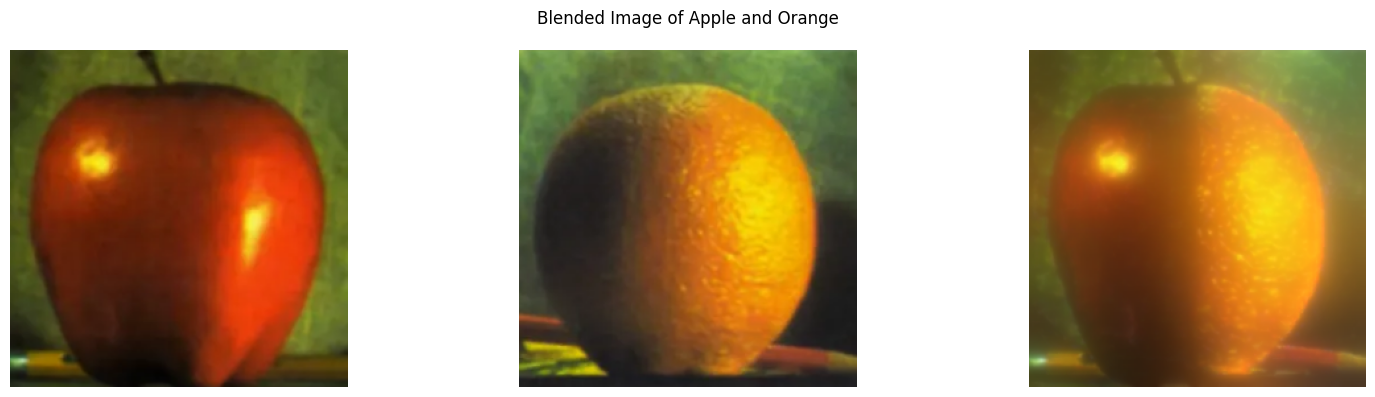

In [10]:
blended_image = laplacian_pyramid_blend_images(to_blend[0], to_blend[1])
collage = np.array([to_blend[0], to_blend[1], blended_image])
show_image_grid(collage, 1, 3, 'Blended Image of Apple and Orange', figsize=16)

### Q3 [4 Marks]

Implement Harris and Hessian Corner Detector algorithm from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Harris and Hessian Corner Detector](https://medium.com/jun94-devpblog/cv-10-local-feature-descriptors-harris-and-hessian-corner-detector-7d524888abfd)

### Harris Detection

In [ ]:
def convolve(image, kernel):
    # Convolution function
    return cv2.filter2D(image, -1, kernel)

def detect_harris_corner(image, k=0.04, threshold=0.01):
    def gaussian_kernel(size, sigma=1.0):
        # Create a Gaussian kernel of a given size and standard deviation.
        ax = np.arange(-size // 2 + 1., size // 2 + 1.)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
        return kernel / np.sum(kernel)

    # Create a copy of the original image
    image_copy = image.copy()

    # Convert the input image to grayscale
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    gray_image = np.float32(gray_image)

    # Define Sobel filters to compute image gradients
    sobel_x = np.array([[1, 0, -1],
                        [2, 0, -2],
                        [1, 0, -1]], dtype=np.float32)
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]], dtype=np.float32)

    # Calculate gradients along x and y axes
    Ix = convolve(gray_image, sobel_x)
    Iy = convolve(gray_image, sobel_y)

    # Calculate products of the gradients
    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    IxIy = Ix * Iy

    # Apply Gaussian filter to smooth the gradient products
    gaussian_filter = gaussian_kernel(3, 1) @ gaussian_kernel(3, 1).T

    # Compute the summed products of derivatives at each pixel
    Sx2 = convolve(Ix2, gaussian_filter)
    Sy2 = convolve(Iy2, gaussian_filter)
    Sxy = convolve(IxIy, gaussian_filter)

    # Calculate the Harris response
    determinant = Sx2 * Sy2 - Sxy ** 2
    trace = Sx2 + Sy2
    R = determinant - k * (trace ** 2)

    # Initialize an image to highlight corners
    corner_image = np.zeros_like(gray_image)
    corner_image[R > threshold * R.max()] = 255

    # Overlay corners on the copied image in blue
    corner_coords = np.argwhere(corner_image == 255)
    for y, x in corner_coords:
        cv2.circle(image_copy, (x, y), 2, (0, 0, 255), -1)  # Draw corners in blue

    return image_copy


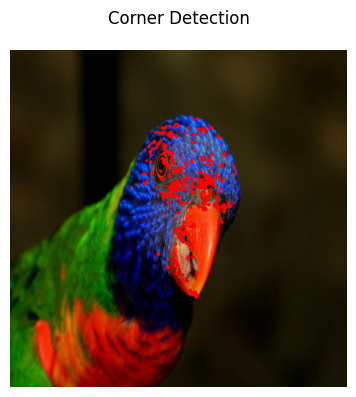

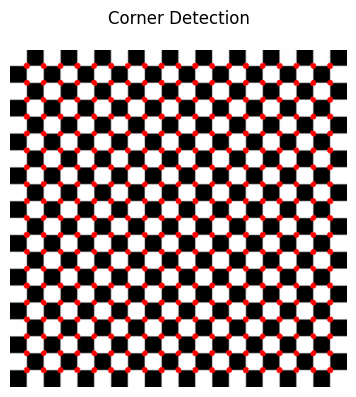

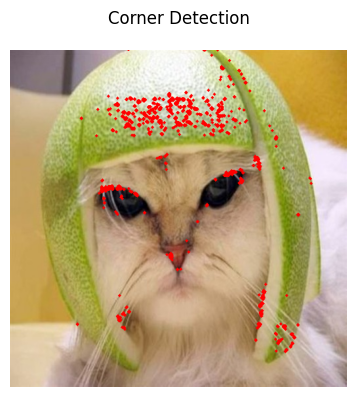

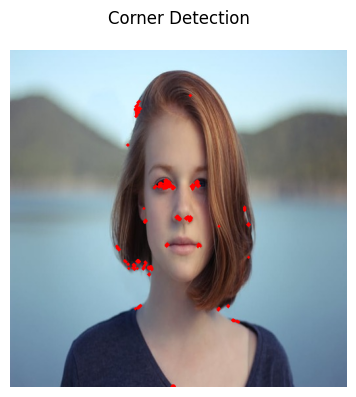

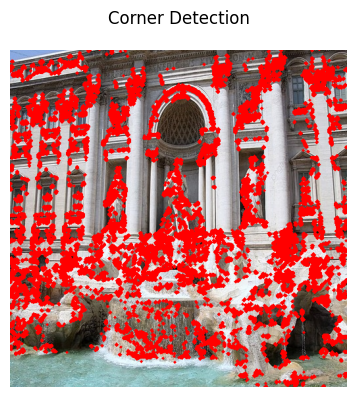

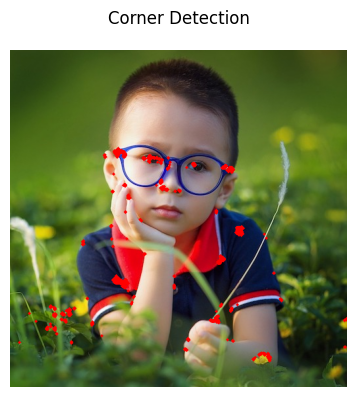

In [ ]:
for image in gt_images:
    corner_image = detect_harris_corner(image)
    show_image_grid(corner_image, 1, 1, 'Corner Detection', figsize=16)

### Hessian Detection

In [ ]:
def hessian_corner_detector(image, threshold=0.01):
    # Create a copy of the original image
    image_copy = image.copy()

    # Convert the input image to grayscale
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    gray_image = np.float32(gray_image)

    # Apply Gaussian blur to reduce noise
    gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Define Sobel kernels for second-order derivatives
    sobel_xx = np.array([[1, -2, 1],
                         [0, 0, 0],
                         [-1, 2, -1]], dtype=np.float32)  # Second derivative w.r.t x

    sobel_yy = np.array([[1, 0, -1],
                         [2, 0, -2],
                         [1, 0, -1]], dtype=np.float32)  # Second derivative w.r.t y

    sobel_xy = np.array([[0, 1, 0],
                         [1, -4, 1],
                         [0, 1, 0]], dtype=np.float32)  # Mixed derivative

    # Calculate second derivatives
    Ixx = convolve(gray_image, sobel_xx)
    Iyy = convolve(gray_image, sobel_yy)
    Ixy = convolve(gray_image, sobel_xy)

    # Compute the Hessian matrix components
    determinant_H = Ixx * Iyy - Ixy ** 2
    trace_H = Ixx + Iyy

    # Compute the response function
    R = determinant_H / (trace_H + 1e-6)  # Avoid division by zero

    # Initialize an image to highlight corners
    corner_image = np.zeros_like(gray_image)

    # Determine maximum response for scaling the threshold
    max_response = R.max()

    # Adjust thresholding based on maximum response
    corner_image[R > threshold * max_response] = 255

    # Overlay corners on the copied image in red
    corner_coords = np.argwhere(corner_image == 255)
    for y, x in corner_coords:
        cv2.circle(image_copy, (x, y), 2, (0, 0, 255), -1)  # Draw corners in red

    return image_copy

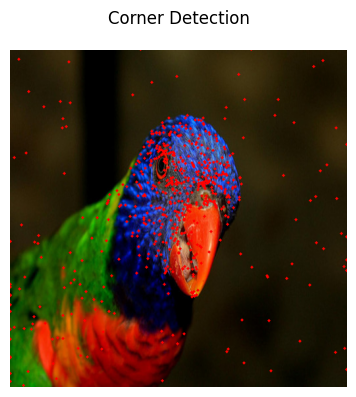

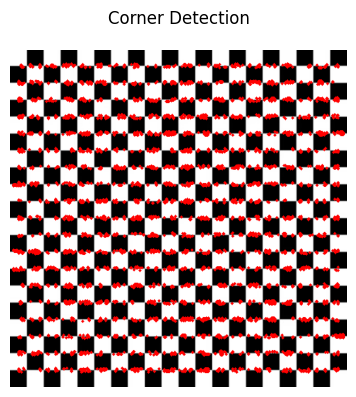

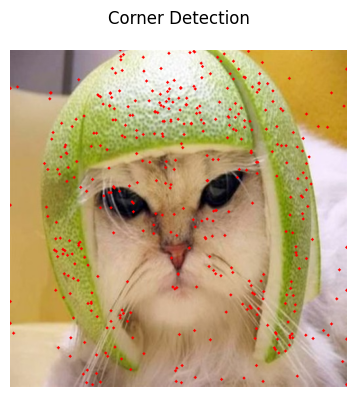

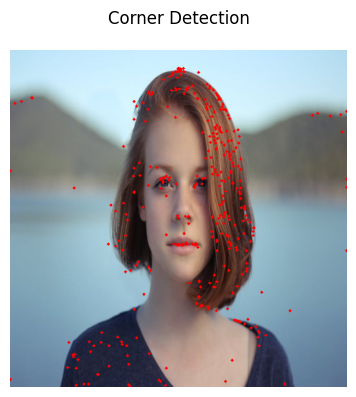

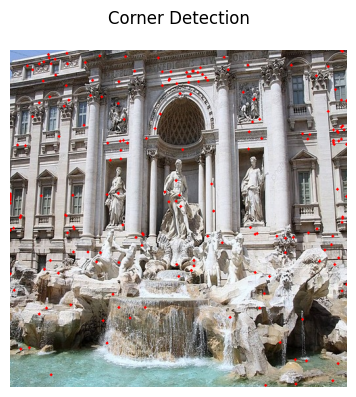

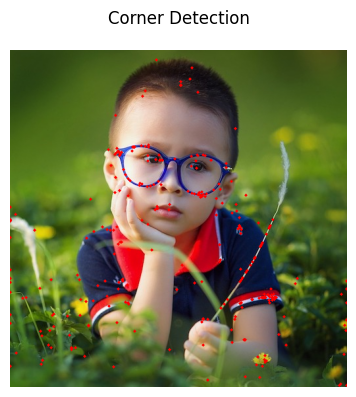

In [ ]:
for image in gt_images:
    corner_image = hessian_corner_detector(image)
    show_image_grid(corner_image, 1, 1, 'Corner Detection', figsize=16)